# 1. Importing and Installing required libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install text_hammer
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import text_hammer as th
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from transformers import AutoTokenizer,TFBertModel
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig
import shutil
import tensorflow as tf
import re
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

/usr/local/lib/python3.7/dist-packages/spacy/language.py:1899: UserWarning: [W123] Argument disable with value [] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  config_value=config["nlp"][key],


# Data Acquisition

In [ ]:
df_full = pd.read_csv('gdrive/MyDrive/nlp/dataset_komentar_instagram_cyberbullying.csv')

In [ ]:
df_full

,Id,Sentiment,Instagram Comment Text
0,1,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,2,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,3,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,4,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,5,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."
...,...,...,...
395,396,positive,Bangga sama suami yg selalu ingat istri disela...
396,397,positive,Apaoun pekerjaannya yg penting halal u tuk men...
397,398,positive,Gojek itu mayoritas pegangguran yang lama gak ...
398,399,positive,<USERNAME> aslinya cantik dan ayu loh mbak kr...


In [ ]:
df_full = df_full.rename(columns={'Sentiment': 'label', 'Instagram Comment Text' : 'tweet'})

In [ ]:
df_full['label'].value_counts(normalize=True)

negative    0.5
positive    0.5
Name: label, dtype: float64

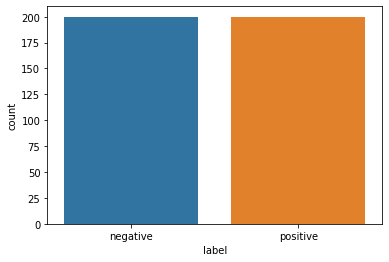

In [ ]:
sns.countplot(df_full['label'],order = df_full['label'].value_counts(normalize=True).index)

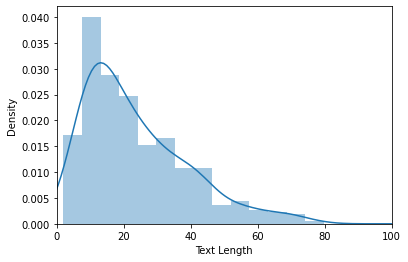

In [ ]:
df_full['num_words'] = df_full['tweet'].apply(lambda x:len(x.split()))
sns.distplot(df_full['num_words'])
plt.xlim([0, 100]);
plt.xlabel('Text Length');

# Preprocessing Data

In [ ]:
abrv = pd.read_csv('gdrive/MyDrive/nlp/abrv.csv')

In [ ]:
abrv

,alias,fix
0,aamiin,amin
1,adek,adik
2,adlh,adalah
3,aer,air
4,aiskrim,es krim
...,...,...
1304,yoi,iya
1305,yup,ya
1306,yups,ya
1307,yupz,ya


In [ ]:
def normalize_abrv(x):
  words = x.split(' ')
  attrfix = abrv[' fix'].tolist()
  attralias = abrv['alias'].tolist()
  normalized = []
  for w in words:
    found = False
    for i, a in enumerate(attralias):
      if w == a: 
        normalized.append(attrfix[i])
        found = True
    if not found: normalized.append(w) 
  return " ".join(normalized)

In [ ]:
normalize_abrv("yoi gaes ak aku bru sm kk")

'iya gaes saya  saya baru  sama  kakak  kakak'

Preserve token

In [ ]:
def preserve_token_enc(t):
    return re.sub(r'(<USERNAME>)', "tokenusername", t)

def preserve_token_dec(t):
    return re.sub(r'(tokenusername)', "[USRNM]", t)

In [ ]:
def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x: preserve_token_enc(x))
    df[column] = df[column].progress_apply(lambda x: str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) 
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    df[column] = df[column].progress_apply(lambda x: re.sub(r'[-+]?[0-9]+', '', x))
    df[column] = df[column].progress_apply(lambda x: normalize_abrv(x))
    df[column] = df[column].progress_apply(lambda x: preserve_token_dec(x))
 
    return(df)

In [ ]:
df_cleaned = text_preprocessing(df_full,'tweet')

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
df_cleaned

,Id,label,tweet,num_words
0,1,negative,[USRNM] tolol tidak tidak ada hubungan nya ke...,35
1,2,negative,geblek kamu kamu tatacowo sangat dibelain ba...,14
2,3,negative,kemarin kemarin termewek sekarang lengket la...,25
3,4,negative,intinya kalau kesal dengan att nya tidak usah...,59
4,5,negative,hadewwwww permpuan itu lgsakit jiwaknp harus d...,20
...,...,...,...,...
395,396,positive,bangga sama suami yang selalu ingat istri dis...,21
396,397,positive,apaoun pekerjaannya yang penting halal you tu...,12
397,398,positive,gojek itu mayoritas pegangguran yang lama tida...,34
398,399,positive,[USRNM] aslinya cantik dan ayu loh mbak karena...,37


In [ ]:
df_cleaned['label'] = df_cleaned['label'].astype('category')
df_cleaned['label'] = df_cleaned['label'].cat.codes
df_cleaned['label'] = df_cleaned['label'].astype('category')

encoded_dict  = {'anger':0,'fear':1, 'happy':2, 'love':3, 'sadness':4}
data_train,data_test = train_test_split(df_cleaned, test_size = 0.2, random_state = 42, stratify = df_cleaned['label'])

In [ ]:
data_train

,Id,label,tweet,num_words
390,391,1,mereka hanya mencari rejeki untuk keluarganya...,16
326,327,1,jangan di dengar kata yang menyakitkan hati ...,31
139,140,0,oh ini toh yang kemarin tidak menghargai kary...,27
119,120,0,[USRNM] please kamu kamu jangan bela pelakori...,36
77,78,0,noraaak abiiis baru kebeli emas az pamer aplg ...,12
...,...,...,...,...
156,157,0,wkwkwkwk ya allah ya tuhan ku kenapa kenapa l...,25
258,259,1,yatuhan suaranyaaaaaaa bagus bangetttttttt,4
49,50,0,astagah suka sama cewek dekil kumel ibaratny...,18
339,340,1,semoga tidak tidak putus lagi ya ka bella sud...,14


# Load Model

In [ ]:
PRE_TRAINED_MODEL = 'indobenchmark/indobert-base-p2'
max_len = 50
num_class = 2
batch_size = 8
learning_rate = 5e-05

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)
bert = TFBertModel.from_pretrained(PRE_TRAINED_MODEL)

Downloading:   0%|          | 0.00/229k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/656M [00:00<?, ?B/s]

Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
bert_tokenizer.add_tokens(['[USRNM]','[URL]','[SEN]'])

3

In [ ]:
x_train = bert_tokenizer(
    text=data_train['tweet'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = True)


x_test = bert_tokenizer(
    text=data_test['tweet'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = True)

In [ ]:
from torch.nn.modules.dropout import Dropout
 
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

embeddings = bert(input_ids, attention_mask = input_mask)[0]
out = tf.keras.layers.Dropout(0.2)(embeddings)
out = tf.keras.layers.GlobalMaxPool1D()(out)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(num_class,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [ ]:
optimizer = Adam(
    learning_rate=learning_rate,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

loss =CategoricalCrossentropy()
metric = CategoricalAccuracy('balanced_accuracy'),
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  124441344   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 50,                                          

# Model fitting and then evaluation

In [ ]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = to_categorical(data_train['label']),
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, to_categorical(data_test['label'])
    ),
  epochs=5,
    batch_size=batch_size
)

Epoch 1/5


40/40 [==============================] - 46s 179ms/step - loss: 0.0694 - balanced_accuracy: 0.9750 - val_loss: 1.2503 - val_balanced_accuracy: 0.8750
Epoch 2/5
40/40 [==============================] - 5s 125ms/step - loss: 0.1612 - balanced_accuracy: 0.9750 - val_loss: 0.6351 - val_balanced_accuracy: 0.8875
Epoch 3/5
40/40 [==============================] - 5s 126ms/step - loss: 0.0225 - balanced_accuracy: 0.9906 - val_loss: 0.6159 - val_balanced_accuracy: 0.9000
Epoch 4/5
40/40 [==============================] - 5s 126ms/step - loss: 0.0470 - balanced_accuracy: 0.9969 - val_loss: 1.5908 - val_balanced_accuracy: 0.8500
Epoch 5/5
40/40 [==============================] - 5s 126ms/step - loss: 0.0491 - balanced_accuracy: 0.9937 - val_loss: 0.5995 - val_balanced_accuracy: 0.8875


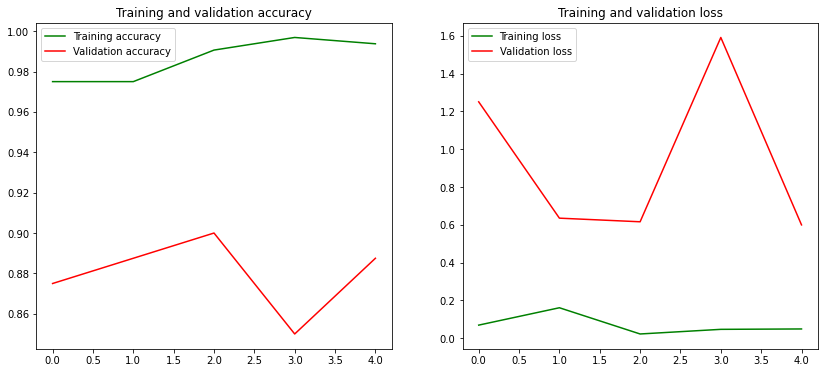

In [ ]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['balanced_accuracy']
    val_acc = hist['val_balanced_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(train_history)

# Test

In [ ]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})
y_predicted = np.argmax(predicted_raw, axis = 1)

3/3 [==============================] - 4s 103ms/step


In [ ]:
accuracy_score(data_test['label'],y_predicted)

0.8875

In [ ]:
print(classification_report(data_test['label'], y_predicted))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89        40
           1       0.92      0.85      0.88        40

    accuracy                           0.89        80
   macro avg       0.89      0.89      0.89        80
weighted avg       0.89      0.89      0.89        80



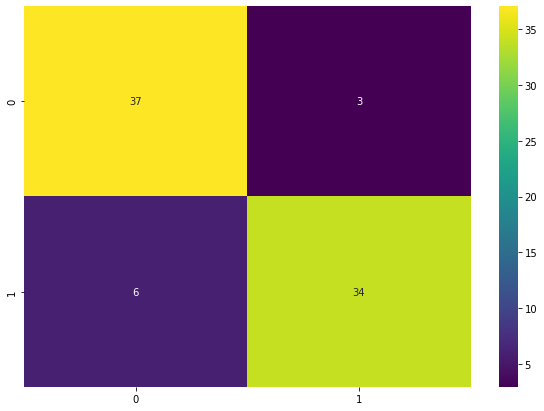

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(data_test['label'],y_predicted),annot=True,cmap='viridis')
plt.show()

# Prediction on custom text

In [ ]:
texts = input(str('input the text'))

x = preserve_token_enc(texts)
x = str(x).lower()
x = th.cont_exp(x)
x = th.remove_special_chars(x)
x = th.remove_accented_chars(x)
x = re.sub(r'[-+]?[0-9]+', '', x)
x = normalize_abrv(x)
x = preserve_token_dec(x)

x_val = bert_tokenizer(
    text=x,
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True) 
validation = model.predict({'input_ids':x_val['input_ids'],'attention_mask':x_val['attention_mask']})*100
for key , value in zip(encoded_dict.keys(),validation[0]):
    print(key,value)

input the texthallo
1/1 [==============================] - 0s 167ms/step
anger 10.2007885
fear 99.06295


In [ ]:
model.save("modelbase.h5")